# Multilayer Perceptron (MLP)

### Definición 

El [Multilayer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (*MLP*) es el tipo de red neuronal profunda (*ANN*, o simplemente *NN*) más simple que existe, en el cual se tienen $l$ capas *fully-connected*, esto es cada neurona de cada capa está conectada a todas las salidas de la capa anterior.

Dicho de otra forma, si $x^{(i)}, y^{(i)}$ son la entrada y la salida de la capa $i$ respectivamente, entonces vale $x^{(i)} = y^{(i-1)}$ y además (omitiendo superíndices $i$):
$$
y = g(W \cdot x + b)
$$

con $x^{(i)} \in \mathbb{R}^{n_{i-1}}, b^{(i)} \in \mathbb{R}^{n_i}, \, W^{(i)} \in \mathbb{R}^{n_{i} \times n_{i-1}}$ donde $n_i$ es la cantidad de neuronas de la capa $i$ y $g: \mathbb{R} \to \mathbb{R}$ es una función no lineal que se aplica en paralelo a cada neurona.


### Esquema de arquitectura

![](https://www.researchgate.net/profile/Khaled-Assi-3/publication/344839529/figure/fig1/AS:949766045315078@1603453279430/Simplified-structure-of-MLP-NN.ppm)

([*créditos*](https://www.researchgate.net/figure/Simplified-structure-of-MLP-NN_fig1_344839529))

### Backpropagation

El algoritmo que permite al MLP entrenarse es *backpropagation* por el cual, para una capa $i$ dada, y dado el gradiente de la función de costo respecto de la salida  $\frac{dJ}{dy^{(i)}}$:

1. Se computa $\frac{dJ}{dW^{(i)}}$ el jacobiano de la función de costo respecto de la matriz de pesos $W$ de la capa
2. Se computa $\frac{dJ}{db^{(i)}}$ el gradiente de la función de costo respecto del vector de sesgos $b$ de la capa
3. Se actualizan $W, b$  de acuerdo a cierta regla de actualización (por ejemplo Adam)
4. Se computa y devuelve $\frac{dJ}{dX^{(i)}}$ el gradiente de la función de costo respecto del vector de entrada, que resulta a su vez $\frac{dJ}{dy^{(i-1)}}$, requerido por la siguiente capa (en orden inverso) para su actualización.

La clave aquí resulta en que cada capa, provista de la derivada del gradiente del error respecto de su salida, puede calcular individualmente su actualización. 

### Predicción

Predecir utilizando un vector de entrada $x$ es tan simple como calcular en forma secuencial la salida de cada capa empezando por la primera. La salida de la última capa será la predicción.

### Entrenamiento

Entrenar una red neuronal $M$ consiste en repetir un número de veces:

1. Seleccionar un número $m$ de observaciones $X$
2. Predecir $\hat{Y}=M_\theta(X)$ utilizando los pesos actuales $\theta$
3. Calcular la función de costo $J(\theta) = \frac{1}{m}\sum_{i=1}^m\mathcal{L}(Y_i, \hat{Y}_i)$
4. Propagar hacia atrás el error a partir de $\frac{dJ}{d\hat{Y}}$.

Donde $m$ suele tomar valores $1$, $m_0 < N$ ó $N$ siendo los casos de *online*, *mini-batch* y *batch* learning respectivamente.




In [ ]:
# lo único que usamos realmente
import numpy as np

# ploteo
import matplotlib.pyplot as plt
import seaborn as sns

# cargado de datasets
from sklearn.datasets import fetch_california_housing


## Clases base

In [ ]:
## La red propiamente dicha 

class MLP(object):
  def __init__(self, dims, optimizer_factory, non_linearities, input_dim, rng_seed = None):
    """
    Multilayer Perceptron class. 

    Params:
    ===============
    dims (list of int): list of number of neurons for each layer, including the output one.
    optimizer_factory (callable): function which returns an Optimizer object upon call.
    non_linearities (list of class): list of nonlinearities to be used after each layer, including the output one.
    input_dim (int): dimension of an individual input.
    rng_seed (int, optional): seed for initialization.

    Note: non_linearities and dims must be of same length.
    """
    # check lengths
    if len(dims) != len(non_linearities):
      raise ValueError("dims' and Non_linearities' lengths do not match")
    
    # initialize RNG
    rng = np.random.default_rng(rng_seed)

    # construct a list of Layers with matching dimension and non-linear activation function
    in_dims = [input_dim] + dims[:-1]
    self.layers = [Layer(n_in, n_out, non_linearity, optimizer_factory, rng) 
                    for n_in,n_out,non_linearity in zip(in_dims,dims, non_linearities)]


  def predict(self, X):
    """
    Produce a prediction for the n samples given in the form of a (input_dim, n) matrix.
    Params:
    ===============
    X (float, shape: input_dim x n): matrix of n samples, each of input_dim dimension.
    """
    # X can be interpreted as the output of a previous layer
    prediction = X

    # sequentially apply forward pass
    for layer in self.layers:
      prediction = layer.forward(prediction)

    return prediction
    
  def update(self, cost_gradient):
    """
    Propagate the errors through the layers.
    Params:
    ===============
    cost_gradient (float, shape: dims[-1] x 1)
    """
    
    # cost gradient is the cost derivative wrt last layer
    dY = cost_gradient

    # sequentially apply backwards update, in reversed order
    for layer in reversed(self.layers):
      dY = layer.backwards(dY)

  def __repr__(self):
    # super hardcoded
    return "MLP with layer sizes: "+ "-".join(str(layer.b.shape[0]) for layer in self.layers)

In [ ]:
class Layer(object):
  def __init__(self, n_in, n_out, non_linearity_class, optimizer_factory, rng):
    self.activation = non_linearity_class()
    self.optim = optimizer_factory()
    self.w = rng.standard_normal(size=(n_out, n_in))  * 0.1 # W shape is (n_out,n_in)
    self.b = rng.uniform(size=(n_out, 1))                   # b shape is (n_out, 1)

    #print(f"W= {self.w.shape}")
    #print(f"b= {self.b.shape}")
    # this may help later :)
    self.last_output = None
    self.last_input = None

  def forward(self, X):
    self.last_input = X
    
    z = self.w @ X + self.b

    self.last_output = self.activation.f(z)

    return self.last_output

  def backwards(self, dY):
    
    dz = dY * self.activation.df()

    dW = dz @ self.last_input.T

    db = np.sum(dz, axis=1, keepdims=True)

    dX = self.w.T @ dz

    self.w, self.b = self.optim.update(self.w, self.b, dW, db)

    return dX

In [ ]:
class NonLinearity(object):

  def __init__(self):
    self.last_z = None
  
  def f(self, z):
    raise NotImplementedError("function evaluation not implemented")

  def df(self):
    raise NotImplementedError("function derivative not implemented")

In [ ]:
class Relu(NonLinearity):

  def __init__(self):
    super().__init__()

  def f(self,z):
    self.last_z = z
    return np.maximum(z,0)

  def df(self):
    return (self.last_z >= 0).astype(float)

In [ ]:
class Identity(NonLinearity):

  def __init__(self):
    super().__init__()

  def f(self,z):
    self.last_z = z
    return z

  def df(self):
    return np.ones_like(self.last_z)  

In [ ]:
class Optimizer(object):

  def update(self, W, b, dW, db):
    raise NotImplementedError("optimizer update rule not implemented")

In [ ]:
class VGD(Optimizer):

  def __init__(self, learning_rate):
    self.lr = learning_rate

  def update(self, W_old, b_old, dW, db):
    # vanilla GD: theta_t+1 = theta_t - alpha * gradient
    W_new = W_old - self.lr * dW
    b_new = b_old - self.lr * db

    return W_new, b_new

def factory_VGD(lr):
  return lambda : VGD(lr)

In [ ]:
class Cost(object):

  def score(self, Y_true, Y_hat):
    raise NotImplementedError("cost scoring function not implemented")

  def derivative(self, Y_true, Y_hat):
    raise NotImplementedError("cost derivative function not implemented")

In [ ]:
class MSE(Cost):

  def score(self, Y_true, Y_hat):
    return 0.5 * np.average(np.square(Y_true - Y_hat))

  def derivative(self, Y_true, Y_hat):
    return (Y_hat - Y_true) / Y_hat.size

In [ ]:
class MAE(Cost):

  def score(self, Y_true, Y_hat):
    return np.average(np.abs(Y_true - Y_hat))

  def derivative(self, Y_true, Y_hat):
    return np.sign(Y_hat - Y_true) / Y_hat.size

In [ ]:
# training procedure

def train_mlp(X_train, y_train, X_test, y_test, model, epochs, verbose=True):
  train_costs_historic = np.empty(epochs, dtype=float)
  test_costs_historic = np.empty(epochs, dtype=float)

  for i in range(epochs):
    # learning on full-batches, but this could be a mini-batch sampling procedure
    x = X_train
    y = y_train

    ## note: as net saves last run, it's important that the run before the update is the train one
    ## so... we predict on test first, then train :)
    test_cost = loss.score(y_test,model.predict(X_test))

    # forward pass
    y_hat = model.predict(x)

    # calculate costs
    train_cost = loss.score(y, y_hat)
    

    # save them, inform the train cost every 20 epochs
    train_costs_historic[i] = train_cost
    test_costs_historic[i] = test_cost

    if((i+1) % 20 == 0) and verbose:
      print(f"Train cost on epoch {i+1} is {train_cost:5.3f}")
    
    # backwards pass
    gradient = loss.derivative(y, y_hat)
    model.update(gradient)

  return train_costs_historic, test_costs_historic

## Aplicación

In [ ]:
# hiperparámetros

lr = 0.001
rng_seed = 6543
epochs = 1000

In [ ]:
X_full, y_full = fetch_california_housing(return_X_y=True)
y_full = y_full.reshape(y_full.shape[0],1)

print(f"X: {X_full.shape}, Y:{y_full.shape}")

X: (20640, 8), Y:(20640, 1)


In [ ]:
# preparing data, train - test validation
# 70-30 split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=rng_seed)

# traspose everything because this NN format assumes column vectors
train_x = X_train.T
train_y = y_train.T
test_x = X_test.T
test_y = y_test.T

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(8, 14448) (1, 14448) (8, 6192) (1, 6192)


Usamos una red chiquita de 1 sola hidden layer

In [ ]:
# initialization

loss = MSE()

nn = MLP(
    dims = [4,y_full.shape[1]], 
    optimizer_factory = factory_VGD(lr), 
    non_linearities = [Relu, Identity], 
    input_dim = X_full.shape[1], 
    rng_seed = rng_seed
)

nn

MLP with layer sizes: 4-1

In [ ]:
train_costs_historic, test_costs_historic = train_mlp(X_train = train_x,
                                                      y_train = train_y,
                                                      X_test = test_x,
                                                      y_test = test_y, 
                                                      model=nn,
                                                      epochs=epochs)

Train cost on epoch 20 is 1.680
Train cost on epoch 40 is 1.638
Train cost on epoch 60 is 1.598
Train cost on epoch 80 is 1.560
Train cost on epoch 100 is 1.524
Train cost on epoch 120 is 1.489
Train cost on epoch 140 is 1.456
Train cost on epoch 160 is 1.424
Train cost on epoch 180 is 1.394
Train cost on epoch 200 is 1.365
Train cost on epoch 220 is 1.337
Train cost on epoch 240 is 1.310
Train cost on epoch 260 is 1.284
Train cost on epoch 280 is 1.260
Train cost on epoch 300 is 1.236
Train cost on epoch 320 is 1.213
Train cost on epoch 340 is 1.192
Train cost on epoch 360 is 1.171
Train cost on epoch 380 is 1.151
Train cost on epoch 400 is 1.132
Train cost on epoch 420 is 1.113
Train cost on epoch 440 is 1.096
Train cost on epoch 460 is 1.079
Train cost on epoch 480 is 1.062
Train cost on epoch 500 is 1.047
Train cost on epoch 520 is 1.032
Train cost on epoch 540 is 1.017
Train cost on epoch 560 is 1.003
Train cost on epoch 580 is 0.990
Train cost on epoch 600 is 0.977
Train cost on 

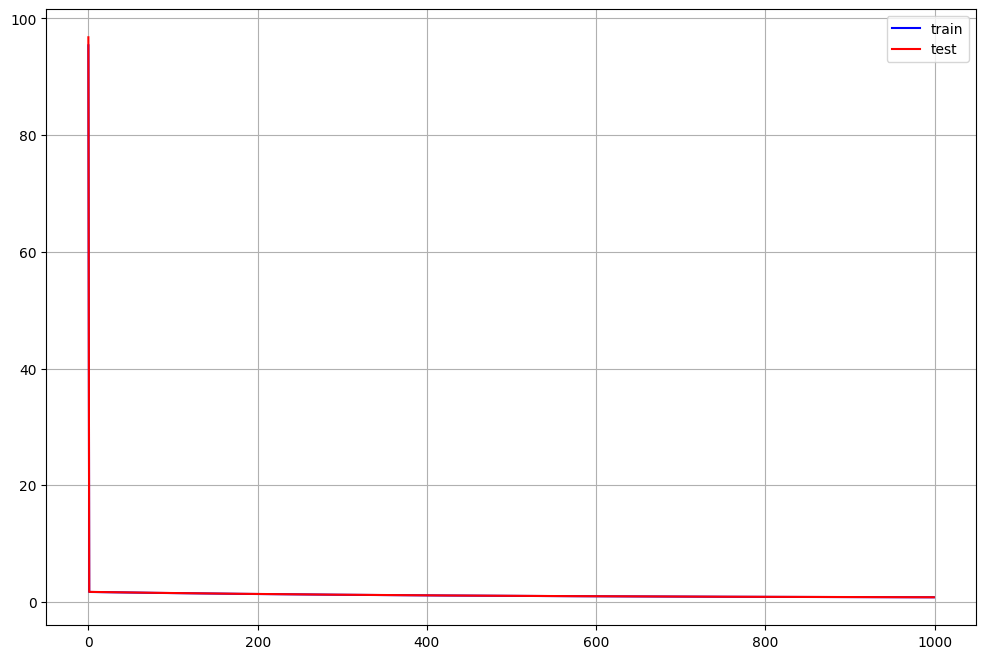

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(train_costs_historic, color='blue', label='train')
plt.plot(test_costs_historic, color='red', label='test')
plt.grid(True)
plt.legend()
plt.show()

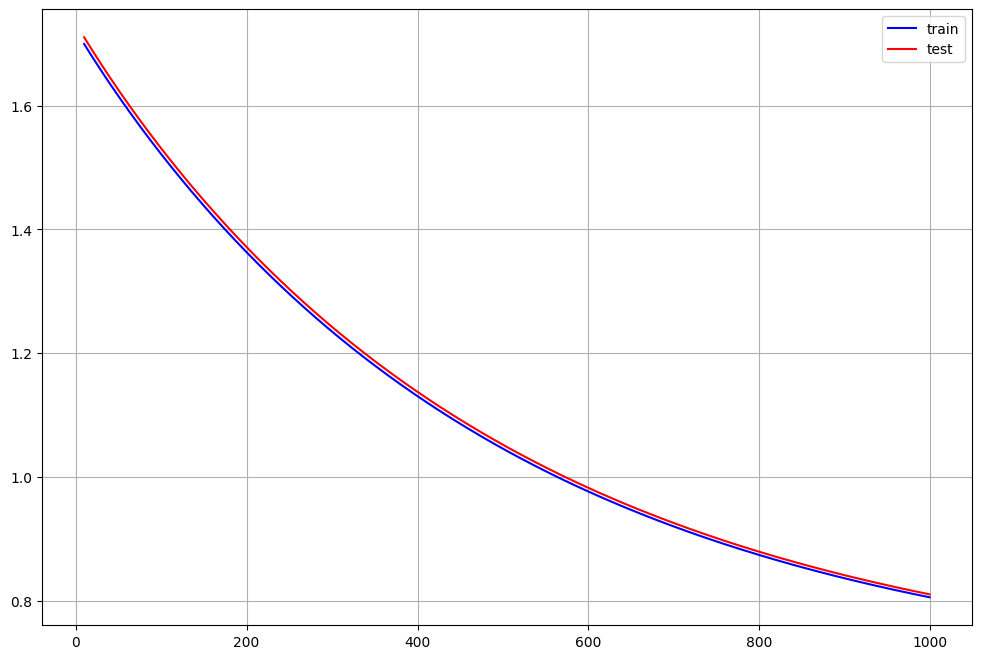

In [ ]:
# first values are off scale, omit first 10
omit_idx = 10
idxs = range(omit_idx, len(train_costs_historic))
plt.figure(figsize=(12,8))
plt.plot(idxs, train_costs_historic[omit_idx:], color='blue', label='train')
plt.plot(idxs, test_costs_historic[omit_idx:], color='red', label='test')
plt.grid(True)
plt.legend()
plt.show()

Una red más grande con 2 hidden layers

In [ ]:
# initialization

loss = MSE()

nn2 = MLP(
    dims = [8,8,y_full.shape[1]], 
    optimizer_factory = factory_VGD(lr), 
    non_linearities = [Relu, Relu, Identity], 
    input_dim = X_full.shape[1], 
    rng_seed = rng_seed
)

nn2

MLP with layer sizes: 8-8-1

In [ ]:
train_costs_historic2, test_costs_historic2 = train_mlp(X_train = train_x,
                                                      y_train = train_y,
                                                      X_test = test_x,
                                                      y_test = test_y, 
                                                      model=nn2,
                                                      epochs=epochs,
                                                      verbose=False)

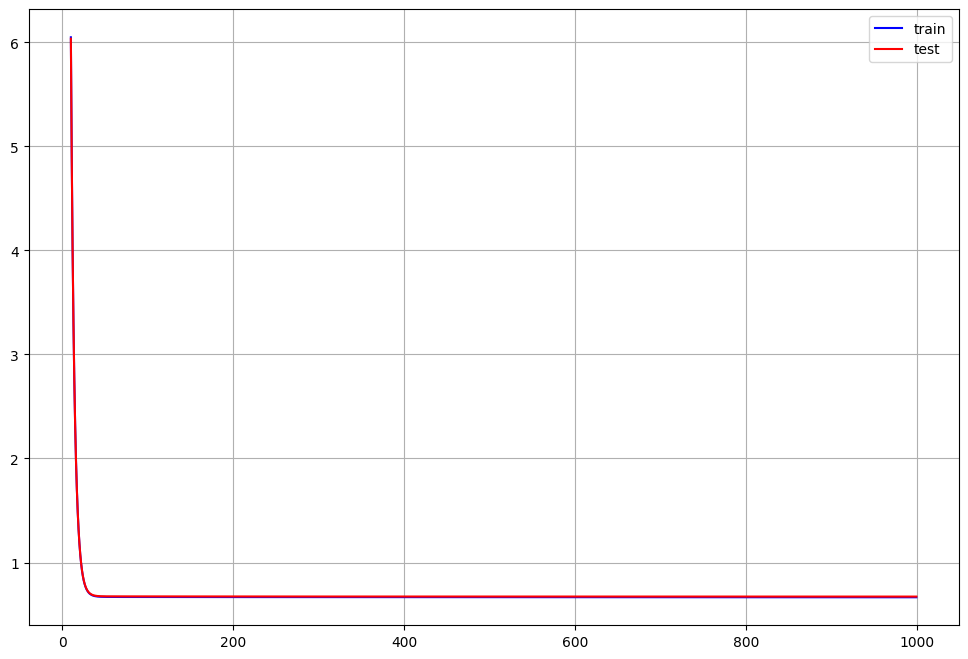

In [ ]:
omit_idx = 10
idxs = range(omit_idx, len(train_costs_historic))
plt.figure(figsize=(12,8))
plt.plot(idxs, train_costs_historic2[omit_idx:], color='blue', label='train')
plt.plot(idxs, test_costs_historic2[omit_idx:], color='red', label='test')
plt.grid(True)
plt.legend()
plt.show()

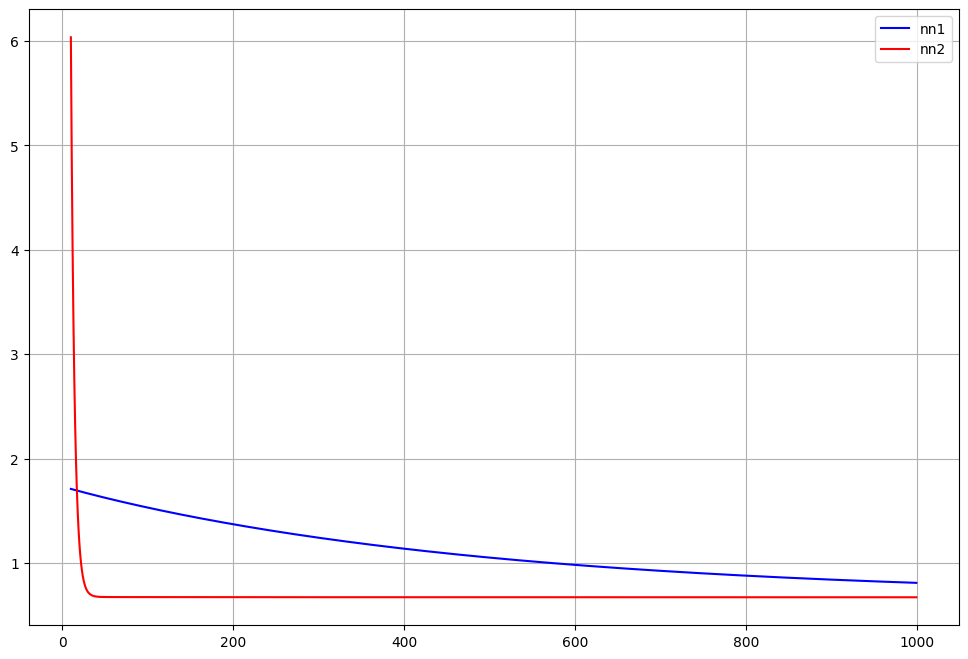

In [ ]:
# compare both test MSEs

omit_idx = 10
idxs = range(omit_idx, len(train_costs_historic))
plt.figure(figsize=(12,8))
plt.plot(idxs, test_costs_historic[omit_idx:], color='blue', label='nn1')
plt.plot(idxs, test_costs_historic2[omit_idx:], color='red', label='nn2')
plt.grid(True)
plt.legend()
plt.show()